# Emergenza COVID-19 italiana

### Importazione librerie e definizioni essenziali

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

show_covm = False # Mostra le matrici di covarianza nei fit

def expf(t, A, k):
    return A*np.exp(k*t)

### Importazione dati
Fonte: [GitHub Protezione Civile](https://github.com/pcm-dpc/COVID-19)

In [2]:
italia = pd.read_json("http://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json")
province = pd.read_json("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-province.json")
regioni = pd.read_json("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json")

print('Dati nazionali aggiornati al', italia.tail(1).iloc[0]['data'])
print('Dati regionali aggiornati al', regioni.tail(1).iloc[0]['data'])
print('Dati provinciali aggiornati al', province.tail(1).iloc[0]['data'])

Dati nazionali aggiornati al 2020-03-29T17:00:00
Dati regionali aggiornati al 2020-03-29T17:00:00
Dati provinciali aggiornati al 2020-03-29T17:00:00


In [3]:
#print(f'Dati nazionali: {italia.columns}')
#print(f'Dati regionali: {regioni.columns}')
#print(f'Dati provinciali: {province.columns}')

## Andamento nazionale

In [4]:
# Scegliere colonna da analizzare (elencati nella cella precedente ^)
it_casi = italia['totale_casi']

tau = 7         # scala temporale di risposta del sistema (~1 settimana)
t_lockdown = 15 # giorno dell'entrata in vigore del DPCM 

t = np.linspace(0, it_casi.size - 1, it_casi.size) - t_lockdown

masks = [(t < 0)]



for i in range(0, it_casi.size // tau):
    test = np.logical_and(t >= (i*tau), t < ((i+1)*tau))
    if test.any():
        masks.append(test)

initp = np.array([1,0.2])

popts = []
pcovs = []

for i, mask in enumerate(masks):
    popt, pcov = curve_fit(expf, t[mask] + t_lockdown, it_casi[mask], initp)
    popts.append(popt)
    pcovs.append(pcov)

for i, (popt, pcov) in enumerate(zip(popts, pcovs)):
    print(f"Fit numerico all'esponenziale - periodo {i}")
    dpopt = np.sqrt(np.diagonal(pcov))
    print(f"\tAmpiezza: {popt[0]} +- {dpopt[0]}")
    print(f"\tEsponente: {popt[1]} +- {dpopt[1]}")
    if show_covm:
        print(f"\tMatrice di covarianza: \t {pcov} \n")

Fit numerico all'esponenziale - periodo 0
	Ampiezza: 398.7969960743963 +- 19.611305717557627
	Esponente: 0.22434096131831022 +- 0.003953367367997255
Fit numerico all'esponenziale - periodo 1
	Ampiezza: 931.5898884258855 +- 101.49705551432436
	Esponente: 0.16306686464057682 +- 0.00565013414642608
Fit numerico all'esponenziale - periodo 2
	Ampiezza: 2463.9071084099946 +- 347.5453113396471
	Esponente: 0.11721567532467578 +- 0.005432499112777178
Fit numerico all'esponenziale - periodo 3
	Ampiezza: 9359.69774181132 +- 627.2547971239546
	Esponente: 0.06923848943556885 +- 0.002097984824276776


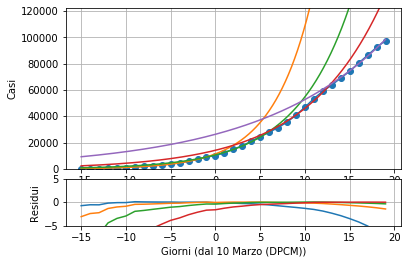

In [5]:
t = np.linspace(0, it_casi.size - 1, it_casi.size) - t_lockdown
tt = np.linspace(0, it_casi.size-1, it_casi.size*100) - t_lockdown

# Dati e fit
plt.subplot2grid((4,1),(0,0), rowspan = 3)
plt.tick_params(labelbottom='off')
plt.grid()
plt.ylabel('Casi')
plt.ylim(0,it_casi.max() * 1.25)

plt.plot(t,it_casi,marker='o')

for popt in popts:
    plt.plot(tt, expf(tt + t_lockdown, *popt))
    
# Residui
plt.subplot2grid((4,1),(3,0))
plt.grid()
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Residui')

for popt in popts:
    plt.ylim(-5,5)
    plt.plot(t, (it_casi - expf(t + t_lockdown, *popt))/it_casi)



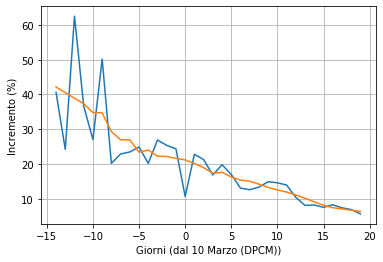

In [6]:
## Incremento percentuale
from scipy.signal import savgol_filter

ratio = (it_casi / np.roll(it_casi,1) - 1) * 100
ratio = ratio[1:]
smoothr = savgol_filter(ratio,7,1)     #magari sostituire con la predizione dei fit
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Incremento (%)')
plt.grid()
plt.plot(t[1:], ratio, label='dati')
plt.plot(t[1:], smoothr, label='dati')

## Andamento regionale

In [7]:
# Scegliere la regione e il campo da analizzare:
regione = 'Toscana'

reg_data = regioni[regioni.denominazione_regione.eq(regione)]
reg_casi = reg_data['totale_casi']

In [8]:
t = np.linspace(0, reg_casi.size - 1, reg_casi.size)

tau = 7         # scala temporale di risposta del sistema (~1 settimana)
t_lockdown = 15 # giorno dell'entrata in vigore del DPCM 
t = t - t_lockdown

masks = [(t < 0)]

for i in range(0, reg_casi.size // tau):
    test = np.logical_and(t >= (i*tau), t < ((i+1)*tau))
    if test.any():
        masks.append(test)

t = t + t_lockdown

initp = np.array([1,0.2])

popts = []
pcovs = []

for i, mask in enumerate(masks):
    popt, pcov = curve_fit(expf, t[mask], reg_casi[mask], initp)
    popts.append(popt)
    pcovs.append(pcov)

for i, (popt, pcov) in enumerate(zip(popts, pcovs)):
    print(f"Fit numerico all'esponenziale - periodo {i}")
    dpopt = np.sqrt(np.diagonal(pcov))
    print(f"\tAmpiezza: {popt[0]} +- {dpopt[0]}")
    print(f"\tEsponente: {popt[1]} +- {dpopt[1]}")
    if show_covm:
        print(f"\tMatrice di covarianza: \t {pcov} \n")

Fit numerico all'esponenziale - periodo 0
	Ampiezza: 1.924443029989637 +- 0.3136340291070721
	Esponente: 0.3373394954267255 +- 0.012494678538916034
Fit numerico all'esponenziale - periodo 1
	Ampiezza: 11.85753133815395 +- 3.1706519857257556
	Esponente: 0.20631043103455793 +- 0.013695057018203206
Fit numerico all'esponenziale - periodo 2
	Ampiezza: 63.24689539109569 +- 14.17370076229027
	Esponente: 0.1319813905224704 +- 0.008598012560626242
Fit numerico all'esponenziale - periodo 3
	Ampiezza: 239.16083886102123 +- 15.137644877665577
	Esponente: 0.0837645792011811 +- 0.0019765018011772225


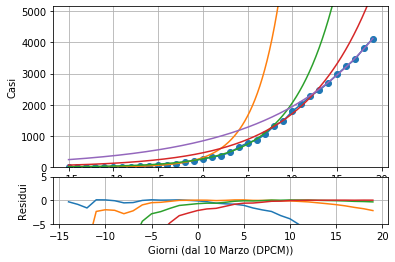

In [9]:
t = np.linspace(0, reg_casi.size - 1, reg_casi.size) - t_lockdown
tt = np.linspace(0, reg_casi.size-1, reg_casi.size*100) - t_lockdown

# Dati e fit
plt.subplot2grid((4,1),(0,0), rowspan = 3)
plt.tick_params(labelbottom='off')
plt.grid()
plt.ylabel('Casi')
plt.ylim(0,reg_casi.max() * 1.25)

plt.plot(t,reg_casi,marker='o')

for popt in popts:
    plt.plot(tt, expf(tt + t_lockdown, *popt))
    
# Residui
plt.subplot2grid((4,1),(3,0))
plt.grid()
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Residui')

for popt in popts:
    plt.ylim(-5,5)
    plt.plot(t, (reg_casi - expf(t + t_lockdown, *popt))/reg_casi)

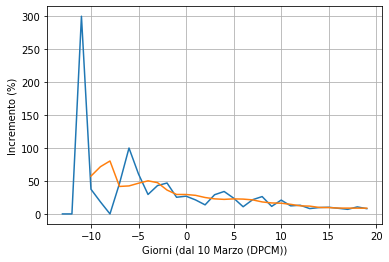

In [10]:
## Incremento percentuale
from scipy.signal import savgol_filter

ratio = (reg_casi / np.roll(reg_casi,1) - 1) * 100
ratio = ratio[1:]
smoothr = savgol_filter(ratio,7,1)     #magari sostituire con la predizione dei fit
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Incremento (%)')
plt.grid()
plt.plot(t[1:], ratio, label='dati')
plt.plot(t[1:], smoothr, label='dati')

## Andamento provinciale

In [11]:
# Scegliere la provincia e il campo da analizzare
provincia = 'PI'

pv_data = province[province.sigla_provincia.eq(provincia)] 
pv_casi = pv_data['totale_casi']

In [12]:
tau = 7         # scala temporale di risposta del sistema (~1 settimana)
t_lockdown = 15 # giorno dell'entrata in vigore del DPCM 
t = np.linspace(0, pv_casi.size - 1, pv_casi.size) - t_lockdown

masks = [(t < 0)]

for i in range(0, pv_casi.size // tau - 1):
    test = np.logical_and(t >= (i*tau), t < ((i+1)*tau))
    if test.any():
        masks.append(test)

t = t + t_lockdown

initp = np.array([1,0.2])

popts = []
pcovs = []

for i, mask in enumerate(masks):
    popt, pcov = curve_fit(expf, t[mask], pv_casi[mask], initp)
    popts.append(popt)
    pcovs.append(pcov)

for i, (popt, pcov) in enumerate(zip(popts, pcovs)):
    print(f"Fit numerico all'esponenziale - periodo {i}")
    dpopt = np.sqrt(np.diagonal(pcov))
    print(f"\tAmpiezza: {popt[0]} +- {dpopt[0]}")
    print(f"\tEsponente: {popt[1]} +- {dpopt[1]}")
    if show_covm:
        print(f"\tMatrice di covarianza: \t {pcov} \n")

Fit numerico all'esponenziale - periodo 0
	Ampiezza: 0.101067996005723 +- 0.04406430255174553
	Esponente: 0.3836755380910738 +- 0.033047120829794066
Fit numerico all'esponenziale - periodo 1
	Ampiezza: 2.2841137867609027 +- 0.7577175955605353
	Esponente: 0.1700373768738426 +- 0.01716567052267689
Fit numerico all'esponenziale - periodo 2
	Ampiezza: 3.7470945323696574 +- 0.8244298168565884
	Esponente: 0.15313501304848787 +- 0.008397527498731445
Fit numerico all'esponenziale - periodo 3
	Ampiezza: 29.181094032022678 +- 6.710513021647945
	Esponente: 0.07906100922918591 +- 0.0071867695502577265


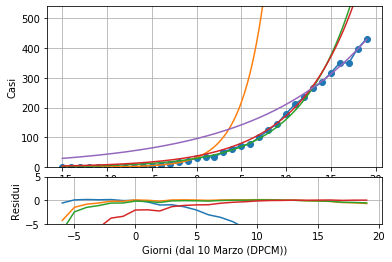

In [13]:
t = np.linspace(0, pv_casi.size - 1, pv_casi.size) - t_lockdown
tt = np.linspace(0, pv_casi.size-1, pv_casi.size*100) - t_lockdown

# Dati e fit
plt.subplot2grid((4,1),(0,0), rowspan = 3)
plt.tick_params(labelbottom='off')
plt.grid()
plt.ylabel('Casi')
plt.ylim(0,pv_casi.max() * 1.25)

plt.plot(t,pv_casi,marker='o')

for popt in popts:
    plt.plot(tt, expf(tt + t_lockdown, *popt))
    
# Residui
plt.subplot2grid((4,1),(3,0))
plt.grid()
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Residui')

for popt in popts:
    plt.ylim(-5,5)
    plt.plot(t, (pv_casi - expf(t + t_lockdown, *popt))/pv_casi)

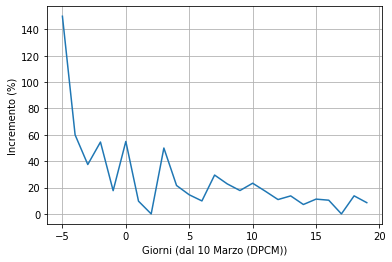

In [14]:
## Incremento percentuale
from scipy.signal import savgol_filter

ratio = (pv_casi / np.roll(pv_casi,1) - 1) * 100
ratio = ratio[1:]
#smoothr = savgol_filter(ratio,15,1)     # non converge
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Incremento (%)')
plt.grid()
plt.plot(t[1:], ratio, label='dati')
#plt.plot(t[1:], smoothr, label='dati')  # non converge